In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from IPython.display import Image

In [ ]:
data_csv = pd.read_csv('/content/drive/My Drive/MiniProject/Water Vessels/train_data/train_data.csv')
print('Data shape: ', data_csv.shape)
categories = {0: 'Cargo', 1:'Military', 2:'Carrier', 3:'Cruise', 4:'Tankers'}
data_csv['category'] = data_csv['category'] - 1
data_csv['label'] = data_csv['category'].map(categories)
data_csv['label']  = pd.Categorical(data_csv['label'])
data_csv.head(5)

Data shape:  (6252, 2)


,image,category,label
0,2823080.jpg,0,Cargo
1,2870024.jpg,0,Cargo
2,2662125.jpg,1,Military
3,2900420.jpg,2,Carrier
4,2804883.jpg,1,Military


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


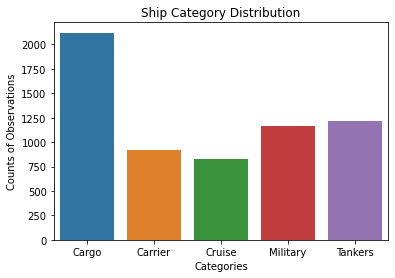

In [ ]:
sns.countplot(data_csv['label'])
plt.title('Ship Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Counts of Observations');

In [ ]:
import cv2

path = '/content/drive/My Drive/MiniProject/Water Vessels/train_data/train_images'

# List of image names
img_list = list(data_csv['image'])

data_img = []

for each in img_list:
    # Each image path
    each_path = os.path.join(path, each)
    # Read each image
    each_img = cv2.imread(each_path)
    # OpenCv default color is BGR. Convert it to RGB
    each_img= cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    # Resize  the images
    each_img_resized = cv2.resize(each_img, (150,150))
    # Save arrays to a list
    data_img.append(each_img_resized)

# Converting list to numpy array
X = np.array(data_img)
print('Shape of X: ', X.shape)

Shape of X:  (6252, 150, 150, 3)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(data_csv['category'].values.reshape(-1,1))
print('Shape of y: ', y.shape)

Shape of y:  (6252, 5)


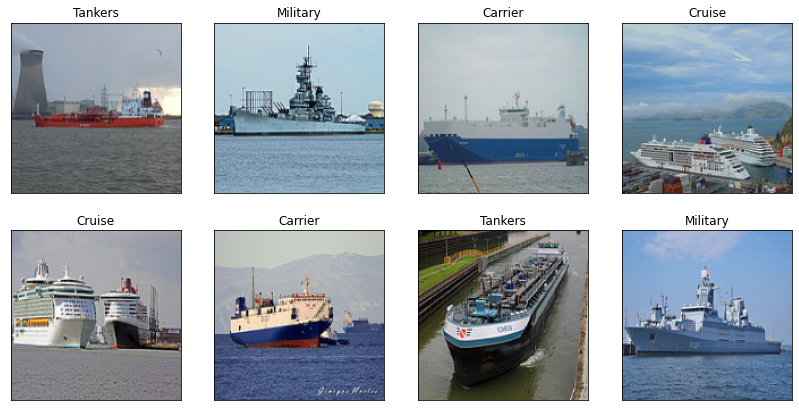

In [ ]:
indices = np.random.randint(0,6252,8) 
i = 1
plt.figure(figsize=(14,7))
for each in indices:
    plt.subplot(2,4,i)
    plt.imshow(X[each])
    plt.title(data_csv['label'].loc[each])
    plt.xticks([])
    plt.yticks([])
    i += 1

In [ ]:
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (4251, 150, 150, 3)
y_train shape:  (4251, 5)
X_val shape  :  (1063, 150, 150, 3)
y_val shape  :  (1063, 5)
X_test shape :  (938, 150, 150, 3)
y_test shape :  (938, 5)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)

validation_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
train_gen.fit(X_train)
validation_gen.fit(X_val)

## 1) Xception Model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

# Defining batch and epoch sizes
batch_size = 32
epochs = 10

# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(150,150,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(5, activation='softmax')(x)
# Combining base and head 
model = Model(inputs=base.input, outputs=head)

# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

# Fitting the model with train and validation augmented datasets.
history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = validation_gen.flow(X_val, y_val, batch_size=batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size)

83697664/83683744 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
132/132 [==============================] - 58s 326ms/step - loss: 0.9759 - accuracy: 0.6196 - val_loss: 0.7200 - val_accuracy: 0.7272
Epoch 2/10
132/132 [==============================] - 41s 309ms/step - loss: 0.5775 - accuracy: 0.7751 - val_loss: 0.5916 - val_accuracy: 0.7733
Epoch 3/10
132/132 [==============================] - 42s 317ms/step - loss: 0.4713 - accuracy: 0.8301 - val_loss: 0.5199 - val_accuracy: 0.7930
Epoch 4/10
132/132 [==============================] - 42s 318ms/step - loss: 0.4203 - accuracy: 0.8445 - val_loss: 0.4181 - val_accuracy: 0.8382
Epoch 5/10
132/132 [==============================] - 42s 320ms/step - loss: 0.3747 - accuracy: 0.8637 - val_loss: 0.3905 - val_accuracy: 0.8551
Epoch 6/10
132/132 [==============================] - 41s 312ms/step - loss: 0.3321 - accuracy: 0.8770 - val_loss: 0.3686 - val_accuracy: 0.8598
Epoch 7/10
132/132 [==============================] - 42s 315ms/step - loss: 0.3044 - accuracy: 0.8862 - val_loss: 0.4270 - val_ac

#### Xception -> Accuracy and Loss

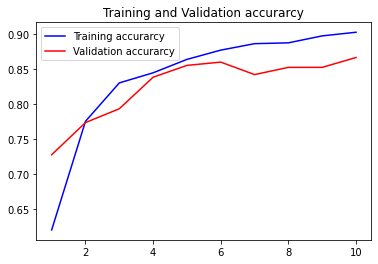

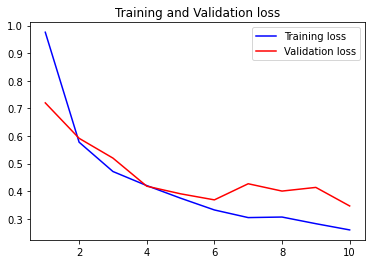

In [ ]:
#lets now plot the train and val curve
import matplotlib.pyplot as plt
#get the details form the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#### Xception -> Confusion matrix

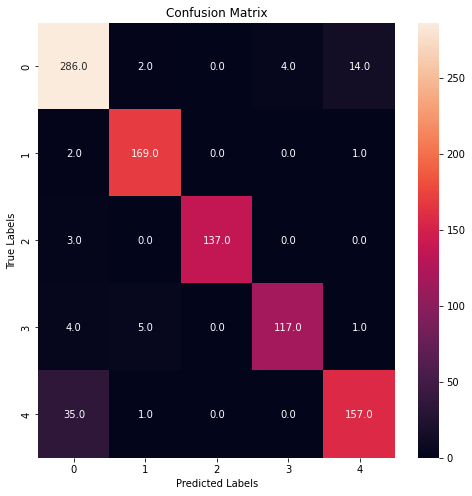

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

#### Xception -> Classificiation Report

In [ ]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       306
           1       0.95      0.98      0.97       172
           2       1.00      0.98      0.99       140
           3       0.97      0.92      0.94       127
           4       0.91      0.81      0.86       193

    accuracy                           0.92       938
   macro avg       0.94      0.93      0.93       938
weighted avg       0.92      0.92      0.92       938



## 2) VGG 16 -> Model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

# Defining batch and epoch sizes
batch_size = 32
epochs = 10

# Defining the pretrained base model
base = VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(5, activation='softmax')(x)
# Combining base and head 
model = Model(inputs=base.input, outputs=head)

# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

# Fitting the model with train and validation augmented datasets.
history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = validation_gen.flow(X_val, y_val, batch_size=batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size)

58900480/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
132/132 [==============================] - 50s 329ms/step - loss: 1.6592 - accuracy: 0.2726 - val_loss: 1.5546 - val_accuracy: 0.3387
Epoch 2/10
132/132 [==============================] - 37s 278ms/step - loss: 1.4112 - accuracy: 0.3821 - val_loss: 1.3017 - val_accuracy: 0.4516
Epoch 3/10
132/132 [==============================] - 37s 277ms/step - loss: 1.2972 - accuracy: 0.4311 - val_loss: 1.1250 - val_accuracy: 0.5466
Epoch 4/10
132/132 [==============================] - 37s 277ms/step - loss: 0.9922 - accuracy: 0.5909 - val_loss: 0.8466 - val_accuracy: 0.6839
Epoch 5/10
132/132 [==============================] - 37s 278ms/step - loss: 0.8102 - accuracy: 0.6824 - val_loss: 0.7171 - val_accuracy: 0.7234
Epoch 6/10
132/132 [==============================] - 37s 278ms/step - loss: 0.7276 - accuracy: 0.7281 - val_loss: 0.7897 - val_accuracy: 0.7008
Epoch 7/10
132/132 [==============================] - 37s 278ms/step - loss: 0.6513 - accuracy: 0.7495 - val_loss: 0.6413 - val_ac

#### VGG16 -> Accuracy and Loss

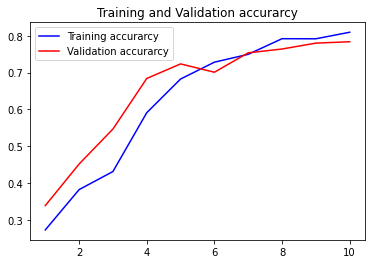

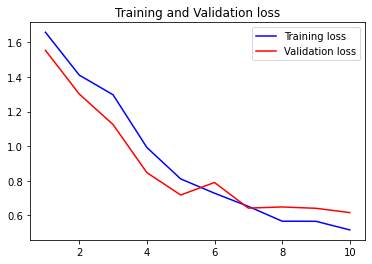

In [ ]:
#lets now plot the train and val curve
import matplotlib.pyplot as plt
#get the details form the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#### VGG16 -> Confusion matrix

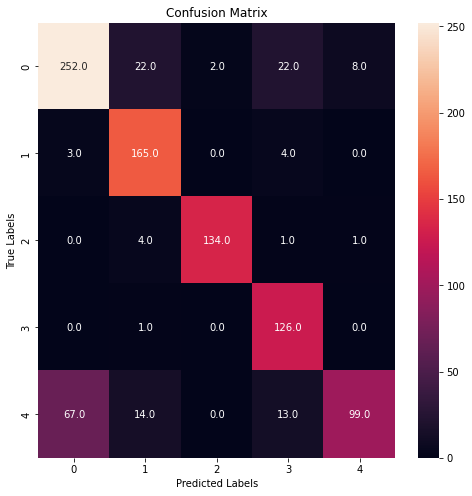

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

#### VGG16 -> Evaluation Matrix

In [ ]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       306
           1       0.80      0.96      0.87       172
           2       0.99      0.96      0.97       140
           3       0.76      0.99      0.86       127
           4       0.92      0.51      0.66       193

    accuracy                           0.83       938
   macro avg       0.85      0.85      0.83       938
weighted avg       0.84      0.83      0.82       938



## 3) ResNet50 -> Model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Defining batch and epoch sizes
batch_size = 32
epochs = 10

# Defining the pretrained base model
base = ResNet50(include_top=False, weights='imagenet', input_shape=(150,150,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(5, activation='softmax')(x)
# Combining base and head 
model = Model(inputs=base.input, outputs=head)

# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

# Fitting the model with train and validation augmented datasets.
history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = validation_gen.flow(X_val, y_val, batch_size=batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size)

94781440/94765736 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
132/132 [==============================] - 46s 293ms/step - loss: 0.8074 - accuracy: 0.6888 - val_loss: 0.7317 - val_accuracy: 0.7432
Epoch 2/10
132/132 [==============================] - 36s 271ms/step - loss: 0.5383 - accuracy: 0.8009 - val_loss: 0.6261 - val_accuracy: 0.7601
Epoch 3/10
132/132 [==============================] - 36s 271ms/step - loss: 0.4546 - accuracy: 0.8322 - val_loss: 0.4728 - val_accuracy: 0.8250
Epoch 4/10
132/132 [==============================] - 36s 273ms/step - loss: 0.3924 - accuracy: 0.8526 - val_loss: 0.5079 - val_accuracy: 0.8260
Epoch 5/10
132/132 [==============================] - 36s 272ms/step - loss: 0.3500 - accuracy: 0.8649 - val_loss: 0.4536 - val_accuracy: 0.8354
Epoch 6/10
132/132 [==============================] - 36s 272ms/step - loss: 0.3179 - accuracy: 0.8794 - val_loss: 0.3662 - val_accuracy: 0.8683
Epoch 7/10
132/132 [==============================] - 36s 271ms/step - loss: 0.2901 - accuracy: 0.8895 - val_loss: 0.5081 - val_ac

#### ResNet 50 -> Accuracy and Loss

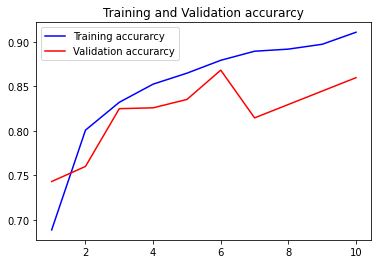

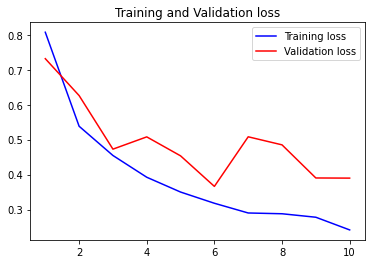

In [ ]:
#lets now plot the train and val curve
import matplotlib.pyplot as plt
#get the details form the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#### ResNet50 -> Confusion matrix

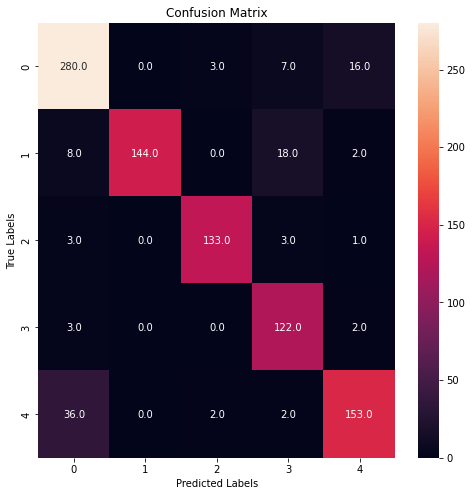

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

#### ResNet50 -> Evaluation Matrix

In [ ]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       306
           1       1.00      0.84      0.91       172
           2       0.96      0.95      0.96       140
           3       0.80      0.96      0.87       127
           4       0.88      0.79      0.83       193

    accuracy                           0.89       938
   macro avg       0.90      0.89      0.89       938
weighted avg       0.89      0.89      0.89       938



## 4) Inception -> Model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Defining batch and epoch sizes
batch_size = 32
epochs = 10

# Defining the pretrained base model
base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(150,150,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(5, activation='softmax')(x)
# Combining base and head 
model = Model(inputs=base.input, outputs=head)

# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

# Fitting the model with train and validation augmented datasets.
history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = validation_gen.flow(X_val, y_val, batch_size=batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size)

219070464/219055592 [==============================] - 3s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
132/132 [==============================] - 73s 406ms/step - loss: 1.0499 - accuracy: 0.5753 - val_loss: 2.3512 - val_accuracy: 0.6453
Epoch 2/10
132/132 [==============================] - 48s 360ms/step - loss: 0.6426 - accuracy: 0.7409 - val_loss: 0.7427 - val_accuracy: 0.7714
Epoch 3/10
132/132 [==============================] - 48s 360ms/step - loss: 0.5321 - accuracy: 0.7969 - val_loss: 0.5828 - val_accuracy: 0.7987
Epoch 4/10
132/132 [==============================] - 47s 359ms/step - loss: 0.4863 - accuracy: 0.8118 - val_loss: 0.6444 - val_accuracy: 0.7667
Epoch 5/10
132/132 [==============================] - 47s 355ms/step - loss: 0.4300 - accuracy: 0.8308 - val_loss: 0.6081 - val_accuracy: 0.8090
Epoch 6/10
132/132 [==============================] - 47s 355ms/step - loss: 0.4123 - accuracy: 0.8376 - val_loss: 0.4872 - val_accuracy: 0.8194
Epoch 7/10
132/132 [==============================] - 47s 357ms/step - loss: 0.3905 - accuracy: 0.8478 - val_loss: 0.6360 - val_ac

#### Inception -> Accuracy and Loss

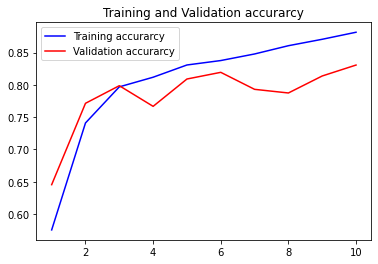

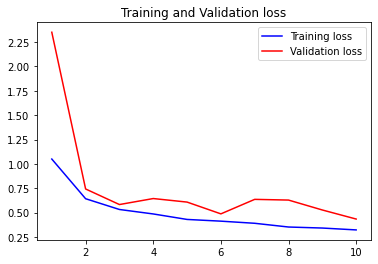

In [ ]:
#lets now plot the train and val curve
import matplotlib.pyplot as plt
#get the details form the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#### Inception -> Confusion matrix

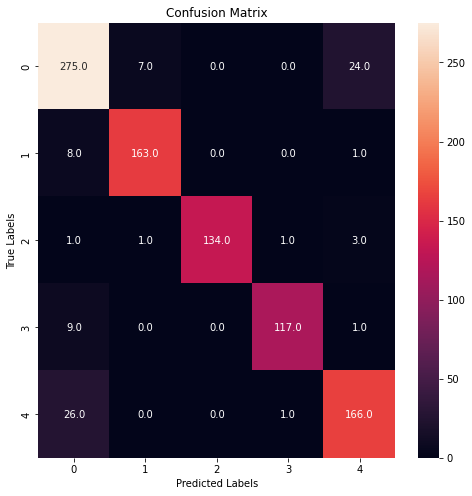

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

#### Inception -> Evaluation Matrix

In [ ]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       306
           1       0.95      0.95      0.95       172
           2       1.00      0.96      0.98       140
           3       0.98      0.92      0.95       127
           4       0.85      0.86      0.86       193

    accuracy                           0.91       938
   macro avg       0.93      0.92      0.92       938
weighted avg       0.91      0.91      0.91       938



## 4) EfficientNetB0 -> Model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# Defining batch and epoch sizes
batch_size = 32
epochs = 10

# Defining the pretrained base model
base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(150,150,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(5, activation='softmax')(x)
# Combining base and head 
model = Model(inputs=base.input, outputs=head)

# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

# Fitting the model with train and validation augmented datasets.
history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = validation_gen.flow(X_val, y_val, batch_size=batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size)

16719872/16705208 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
132/132 [==============================] - 53s 324ms/step - loss: 1.0660 - accuracy: 0.5734 - val_loss: 0.7097 - val_accuracy: 0.7140
Epoch 2/10
132/132 [==============================] - 35s 262ms/step - loss: 0.6059 - accuracy: 0.7627 - val_loss: 0.5105 - val_accuracy: 0.8034
Epoch 3/10
132/132 [==============================] - 35s 263ms/step - loss: 0.4976 - accuracy: 0.8023 - val_loss: 0.4671 - val_accuracy: 0.8109
Epoch 4/10
132/132 [==============================] - 35s 262ms/step - loss: 0.4416 - accuracy: 0.8336 - val_loss: 0.4286 - val_accuracy: 0.8325
Epoch 5/10
132/132 [==============================] - 35s 265ms/step - loss: 0.3844 - accuracy: 0.8540 - val_loss: 0.4005 - val_accuracy: 0.8495
Epoch 6/10
132/132 [==============================] - 35s 264ms/step - loss: 0.3573 - accuracy: 0.8706 - val_loss: 0.3488 - val_accuracy: 0.8711
Epoch 7/10
132/132 [==============================] - 35s 266ms/step - loss: 0.3370 - accuracy: 0.8732 - val_loss: 0.3678 - val_ac

#### EfficientNetB0 -> Accuracy and Loss

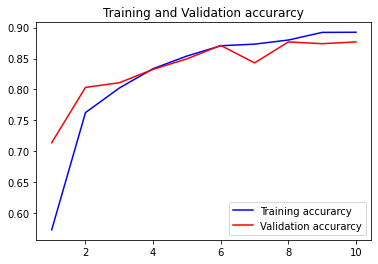

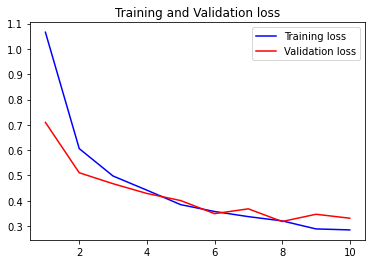

In [ ]:
#lets now plot the train and val curve
import matplotlib.pyplot as plt
#get the details form the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#### EfficientNetB0 -> Confusion matrix

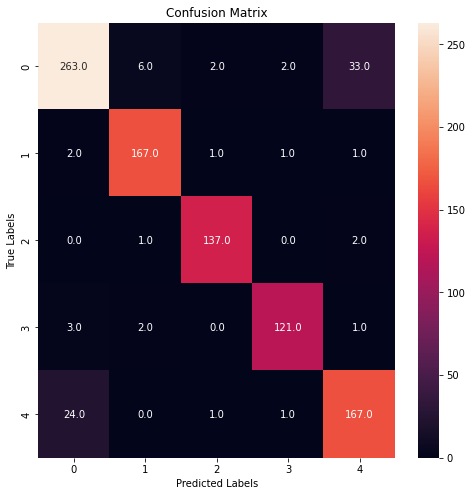

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

#### EfficientNetB0 -> Evaluation Matrix

In [ ]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       306
           1       0.95      0.97      0.96       172
           2       0.97      0.98      0.98       140
           3       0.97      0.95      0.96       127
           4       0.82      0.87      0.84       193

    accuracy                           0.91       938
   macro avg       0.92      0.93      0.92       938
weighted avg       0.91      0.91      0.91       938

